In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scanpy as sc
import networkx as nx
from collections import Counter
import scipy
from anytree import Node, RenderTree, LevelOrderGroupIter

from importlib import reload

In [31]:
# load the HWG
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/HWG/HWG.scanpy.h5ad"
hwg = sc.read_h5ad(fpath)
hwg

AnnData object with n_obs × n_vars = 19198 × 19198
    obs: 'gene_name', 'transcription_factor', 'self_loop', 'master_regulator', 'MR', 'TF'
    var: 'gene_name', 'transcription_factor', 'self_loop', 'master_regulator', 'MR', 'TF'

In [32]:
# compute quick summary stats
total_vals = hwg.X.sum()
sparsity = 100 - (hwg.X.sum() / hwg.X.todense().size) * 100
print(f"{total_vals=}")
print(f"{sparsity=:.3f}")

total_vals=11705431
sparsity=96.824


In [34]:
# how many TFs?
hwg.obs['TF'].value_counts()

TF
False    17579
True      1619
Name: count, dtype: int64

In [37]:
def hwg_as_network(hwg):
    """Converts a hard-wired genome (`hwg`) into a NetworkX graph.

    Args:
        hwg: The hard-wired genome object.

    Returns:
        nx.Graph: The NetworkX graph representing the genome structure.
    """
    # 1. Direct Adjacency Conversion
    G = nx.from_pandas_adjacency(hwg.to_df())

    # 2. Simplified Attribute Update
    nx.set_node_attributes(G, hwg.obs.to_dict('index'))
    
    return G

G = hwg_as_network(hwg)
G
    

In [101]:
def get_interaction_tree(G, source, max_order):
    """Retrieves interactions from a source node within a specified maximum order.

    Args:
        G (nx.Graph): The NetworkX graph.
        source: The source node.
        max_order (int, optional): The maximum order (distance) from the source. Defaults to 1.

    Returns:
        pd.DataFrame: A DataFrame with columns 'step_0', 'step_1', ..., up to 'step_{max_order}',
                      containing nodes reached at each order.
    """
    paths = nx.single_source_shortest_path(G, source, cutoff=max_order).values()
    
    # Construct DataFrame with NaN Filling
    df = pd.DataFrame(paths).fillna("None")
    df.columns = [f"step_{i}" for i in range(len(df.columns))]
    return df
    
paths = get_interaction_tree(G, 
                             source='GATA2', 
                             max_order=3) 

print(f"{paths.shape=} ({paths.shape[0] / hwg.X.shape[0]:.4f})")
paths.head()

paths.shape=(19198, 4) (1.0000)


,step_0,step_1,step_2,step_3
0,GATA2,None,None,None
1,GATA2,FGR,None,None
2,GATA2,NFYA,None,None
3,GATA2,WNT16,None,None
4,GATA2,PLXND1,None,None


In [105]:
def get_path_counts(paths):
    """Analyzes path counts in a given data structure.

    Args:
        paths: The data structure containing paths (e.g., DataFrame, Series, list of lists).

    Returns:
        pd.DataFrame: A DataFrame containing genes sorted by count (descending),
                      with columns 'Gene', 'Count', and 'Percentage'.
    """
    # Flatten the paths into a single list and count occurrences
    counts = Counter(paths.values.ravel())
    total_count = sum(counts.values())

    # Create DataFrame
    pdf = pd.DataFrame.from_dict(counts, orient='index', columns=['Count'])
    pdf.index.name = 'Gene'  # Name the index column 'Gene'
    pdf = pdf.reset_index()  # Move 'Gene' to a regular column
    
    # Calculate percentage
    pdf['Percentage'] = (pdf['Count'] / total_count) * 100
    
    # Sort by count (descending)
    pdf = pdf.sort_values(by='Count', ascending=False)
    
    return pdf

counts = get_path_counts(paths)
counts.head()

,Gene,Count,Percentage
1,None,20955,27.287999
0,GATA2,19198,25.000000
2,FGR,1031,1.342588
11,CREBBP,896,1.166788
7,KDM1A,863,1.123815


In [ ]:
break

# Cell type specific data

In [106]:
# load BJ data
df = pd.read_csv("/nfs/turbo/umms-indikar/shared/projects/R01/merged_fib_data.csv")
print(f"{df.shape=}")

df.head()

df.shape=(18988, 4)


,gene_name,chen_fibroblast_2015,liu_fibroblast_2018,ac_bj_fibroblast
0,A1BG,0.070114,0.134265,4.414373
1,A1CF,0.000482,0.000000,0.000000
2,A2M,0.000773,0.000000,2.748552
3,A2ML1,0.000232,0.000000,0.076961
4,A3GALT2,0.000000,0.000000,0.000000


In [108]:
n = 2000
col = 'chen_fibroblast_2015'

pdf = df.copy()
pdf = pdf[pdf['gene_name'].isin(hwg.var_names)]
pdf = pdf.set_index('gene_name')

pdf = pdf.sort_values(by=col, ascending=False)

genes = pdf.head(n).index
print(len(genes))

2000


<Axes: xlabel='value', ylabel='Count'>

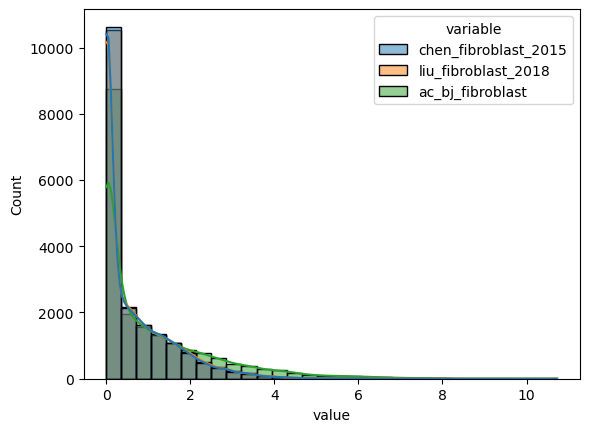

In [ ]:
pdf = df.copy()
pdf = pd.melt(pdf, id_vars='gene_name')

sns.histplot(data=pdf, 
             x='value',
             hue='variable',
             kde=True,
             bins=30)

In [ ]:
# different thresholds

pdf = df.copy()
pdf = pd.melt(pdf, id_vars='gene_name')

res = []


for t in np.linspace(0.001, 10, 100):
    
    tdf = pdf[pdf['value'] > t]
    tdf = tdf.groupby('variable')['gene_name'].count().to_dict()
    tdf['threshold'] = t
    res.append(tdf)
    
res = pd.DataFrame(res)
res = pd.melt(res, id_vars='threshold')

sns.lineplot(data=res, 
             x='threshold',
             y='value',
             hue='variable')

# generate a mask

In [ ]:
n = 2000
col = 'chen_fibroblast_2015'

pdf = df.copy()
pdf = pdf[pdf['gene_name'].isin(hwg.var_names)]
pdf = pdf.set_index('gene_name')

pdf = pdf.sort_values(by=col, ascending=False)

genes = pdf.head(n).index
print(len(genes))

# Get FOI

In [ ]:
tfs = hwg.var[hwg.var['is_TF'] == "1"]['gene_name'].values
print(len(tfs))

In [ ]:
TFS = [
    'GATA2', 
    "GFI1B",
    "REL", 
    "STAT5A",
    "FOS",
]

foi = hwg[:, TFS].to_df()
foi = foi.loc[genes]

foi['row_sums'] = foi.sum(axis=1)
foi = foi.sort_values(by='row_sums', ascending=False)

outpath = "/home/cstansbu/temp/reprogramming_foi.csv"
foi = foi.reset_index()
foi['is_TF'] = foi['gene_name'].isin(tfs)
foi = foi[foi['row_sums'] > 0]
foi.to_csv(outpath, index=False)
print(f"{foi.shape=}")
foi

In [ ]:
# break

In [ ]:
top = 20
print(foi.head(top).to_latex(index=False))

# generate a walker

In [ ]:
tfs = hwg.var[hwg.var['is_TF'] == "1"]['gene_name'].values
print(len(tfs))

In [ ]:
def get_first_order_interactions(hwg, gene, tf_only=True):
    """Retrieves first-order interactions for a given gene from a hard-wired genome.

    Args:
        hwg: The hard-wired genome data structure (assumes it has a `to_df()` method and obs['is_TF'] if applicable).
        gene: The name of the gene to find interactions for.
        tf_only: If True, filter interactions to only include transcription factors.

    Returns:
        A pandas Index containing the names of the interacting genes.
    """
    if tf_only:
        X = hwg[hwg.obs['is_TF'] == "1", gene].to_df()
    else:
        X = hwg[:, gene].to_df()
        
    return list(X[X[gene] > 0].index)

i = get_first_order_interactions(hwg, 'GATA2', tf_only=True)
len(i)

In [ ]:
def add_children(children, parent, nodes):
    """Adds child nodes to a parent node in a tree structure.

    This function takes a list of child gene names, a parent gene name, and a dictionary of existing nodes. 
    It creates new child nodes for each gene in the `children` list, assigning the `parent` as their parent node, 
    and adds them to the `nodes` dictionary.

    Args:
        children: A list of gene names representing the child nodes to add.
        parent: The gene name representing the parent node to which the children should be added.
        nodes: A dictionary mapping gene names to their corresponding Node objects in the tree structure.

    Returns:
        The updated `nodes` dictionary with the new child nodes added.
    """

    if parent not in nodes:
        for gene in children:
            nodes[gene] = Node(gene, parent=parent)
    return nodes

def get_k_order_interactions(hwg, root_gene, k, tf_only=True):
    """
    Retrieves k-order interactions for a gene from a hard-wired genome as a tree.

    Args:
        hwg: The hard-wired genome data structure.
        root_gene: The gene name to start the interaction search from.
        k: The maximum order of interactions to explore.
        tf_only: If True, filter interactions to only include transcription factors.
        current_depth: Current depth of recursion (starts at 0).
        parent: The parent node (used for recursion).

    Returns:
        The root node of the interaction tree.
    """

    # init first order interactions
    root = Node(root_gene) # Create the root node if it's the first call
    children = get_first_order_interactions(hwg, root_gene, tf_only)
    
    nodes = {
        root_gene : root
    }
    nodes = add_children(children, root, nodes)
    
    for i in range(2, k):
        child_nodes = [node for node in LevelOrderGroupIter(root, maxlevel=i)][i-1]
        for child in child_nodes:
            gene = nodes[child.name]
            children = get_first_order_interactions(hwg, child.name, tf_only)
            nodes = add_children(children, gene, nodes)
    return root, nodes
        
k = 3
show = 2
root, nodes = get_k_order_interactions(hwg, 'STAT5A', k=k)
print(f"{len(nodes)}")

In [ ]:
def output_tree(root, level=4):
    """A function to store the tree as a tabular structure"""
    res = []
    
    for layer in list(LevelOrderGroupIter(root, maxlevel=level)):
        for entry in layer:

            path = entry.path[-1].__str__()
            path = path.replace("Node('", "").replace("')", "").strip()
            row = {}
            for i, node in enumerate(path.split("/")[1:]):
                row[f"order_{i}"] = node
            res.append(row)

    res = pd.DataFrame(res)
    res = res.fillna("None")
    return res
    
    
df = output_tree(root)
print(f"{df.shape=}")
df.head()

In [ ]:
df['order_1'].value_counts()

# do a few genes

In [ ]:
TFS = [
    'GATA2', 
    "GFI1B",
    "REL", 
    "STAT5A",
    "FOS",
]

k = 4

outdir = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/HWG/"

df = []

for tf in TFS:
    root, _ = get_k_order_interactions(hwg, tf, k=k)
    tmp = output_tree(root)
    outpath = f"{outdir}{tf}_k{k}.csv"
    tmp.to_csv(outpath, index=False)
    print(f"{tf} {tmp.shape=}")    
    
    df.append(tmp)
    
df = pd.concat(df)
print(df.head())

In [ ]:
df.sample(10)

In [ ]:
top = 20
print(df.sample(top).to_latex(index=False))

# Score the interactions

In [ ]:
pdf = Counter(df.values.ravel())
pdf = pd.DataFrame.from_dict(pdf, 
                             orient='index', 
                             columns=['Count']) 
pdf = pdf.reset_index()
pdf.columns = ['Gene', 'Count']
pdf = pdf.sort_values(by='Count', ascending=False)
pdf.head(15)

# A global analysis

In [ ]:
TFS = [
    'GATA2', 
    "GFI1B",
    "REL", 
    "STAT5A",
    "FOS",
]

k = 3

df = []

for tf in TFS:
    root, _ = get_k_order_interactions(hwg, tf, k=k, tf_only=False)
    tmp = output_tree(root)
    outpath = f"{outdir}{tf}_k{k}.csv"
    print(f"{tf} {tmp.shape=}")    
    df.append(tmp)
    
df = pd.concat(df)
print(df.head())

In [ ]:
df['order_3'].value_counts()